# Klasyfikator klasyczny

In [1]:
%matplotlib inline
%tensorflow_version 2.x

## Struktura sieci

Zaczniemy od prostej sieci splotowej. Struktura będzie podobna do sieci przedstawionej na zajęciach z klasyfikacji, a więc dwie warstwy splotowe, spłaszczenie i klasyfikator z jedną warstwą ukrytą. Ponownie wykorzystamy zestaw danych MNIST.

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

import tensorflow as tf

from keras.datasets import mnist     # MNIST dataset is included in Keras%
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers import BatchNormalization

from keras import optimizers


from sklearn.metrics import confusion_matrix
import itertools

In [3]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [5]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [6]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [7]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(16, (5, 5), input_shape=(28,28,1))) # 16 different 5x5 kernels -- so 16 feature maps
model.add(Activation('relu') )                       # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 2
model.add(Conv2D(32, (5, 5)))                        # 32 different 5x5 kernels -- so 32 feature maps
model.add(Activation('relu'))                        # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

model.add(Flatten())                                 # Flatten final output matrix into a vector

# Fully Connected Layer 
model.add(Dense(128))                                # 128 FC nodes
model.add(Activation('relu'))                        # activation

# Fully Connected Layer                        
model.add(Dense(10))                                 # final 10 FC nodes
model.add(Activation('softmax'))                     # softmax activation

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 activation (Activation)     (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          12832     
                                                                 
 activation_1 (Activation)   (None, 8, 8, 32)          0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                    

In [8]:
# we'll use the same optimizer
adam = tf.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## Trening na obrazach 28x28 px

In [9]:
model.fit(train_generator, steps_per_epoch=48000//128, epochs=5, verbose=1, validation_data=valid_generator, validation_steps = 12000 // 128)

Epoch 1/5
375/375 [==============================] - 35s 65ms/step - loss: 0.4388 - accuracy: 0.8658 - val_loss: 0.1459 - val_accuracy: 0.9567
Epoch 2/5
375/375 [==============================] - 22s 58ms/step - loss: 0.1279 - accuracy: 0.9616 - val_loss: 0.1013 - val_accuracy: 0.9690
Epoch 3/5
375/375 [==============================] - 21s 56ms/step - loss: 0.0936 - accuracy: 0.9710 - val_loss: 0.0757 - val_accuracy: 0.9765
Epoch 4/5
375/375 [==============================] - 22s 60ms/step - loss: 0.0749 - accuracy: 0.9762 - val_loss: 0.1050 - val_accuracy: 0.9700
Epoch 5/5
375/375 [==============================] - 24s 63ms/step - loss: 0.0666 - accuracy: 0.9797 - val_loss: 0.0689 - val_accuracy: 0.9780


In [10]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 4ms/step - loss: 0.0310 - accuracy: 0.9909
Test score: 0.03099837712943554
Test accuracy: 0.9908999800682068


## Detekcja oknem przesuwnym

In [11]:
!wget https://raw.githubusercontent.com/wut-mpg/ColabNotebooks/main/test.png

--2022-05-05 18:50:01--  https://raw.githubusercontent.com/wut-mpg/ColabNotebooks/main/test.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3583 (3.5K) [image/png]
Saving to: ‘test.png’

test.png            100%[===================>]   3.50K  --.-KB/s    in 0s      

2022-05-05 18:50:01 (43.7 MB/s) - ‘test.png’ saved [3583/3583]



(56, 196, 1)
(1, 56, 196, 1)


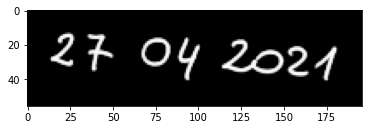

In [12]:
from keras.preprocessing.image import load_img, img_to_array

img = load_img('test.png', color_mode = "grayscale")
img = img_to_array(img).astype(np.float32) / 255.
print(img.shape)
plt.imshow(img[:,:,0], cmap = 'gray')
img = np.expand_dims(img, 0)
print(img.shape)

In [13]:
step = 4
sz = 28

xc = (img.shape[2]-sz) // step + 1
yc = (img.shape[1]-sz) // step + 1

hmap = np.zeros((yc,xc,10))

for x in range(xc):
  for y in range(yc):
    crop = img[:,y*step:y*step+sz,x*step:x*step+sz,:]
    hmap[y,x,:] = model.predict(crop)

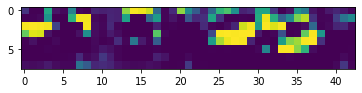

In [14]:
plt.imshow(hmap[:,:,2])

# Sieć w pełni splotowa

Metoda z oknem przesuwnym jest skuteczna, ale skomplikowana obliczeniowo. Niektóre obszary obrazu analizowane są wielokrotnie dla sąsiadujących okien, co niepotrzebnie wydłuża cały proces. Zmiana struktury sieci na w pełni splotową pozwoli na ograniczenie tego problemu.

## Struktura sieci

In [15]:
modelfc = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
modelfc.add(Conv2D(16, (5, 5), input_shape=(None,None,1))) # 16 different 5x5 kernels -- so 16 feature maps
modelfc.add(Activation('relu') )                       # activation
modelfc.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 2
modelfc.add(Conv2D(32, (5, 5)))                        # 32 different 5x5 kernels -- so 32 feature maps
modelfc.add(Activation('relu'))                        # activation
modelfc.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel


modelfc.add(Conv2D(128, (4, 4)))                        
modelfc.add(Activation('relu'))                        # activation

modelfc.add(Conv2D(10, (1, 1)))                              
modelfc.add(Activation('softmax'))                     # softmax activation

modelfc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, None, None, 16)    416       
                                                                 
 activation_4 (Activation)   (None, None, None, 16)    0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 32)    12832     
                                                                 
 activation_5 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                  

In [16]:
adam = tf.optimizers.Adam(learning_rate=0.001)
modelfc.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## Trening na obrazach 28x28 px

In [17]:
Y_train_fc = np.reshape(Y_train, (60000, 1, 1, 10))
Y_test_fc = np.reshape(Y_test, (10000, 1, 1, 10))
print(Y_test_fc.shape)

(10000, 1, 1, 10)


In [18]:
gen_fc = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen_fc = ImageDataGenerator()

train_generator_fc = gen_fc.flow(X_train, Y_train_fc, batch_size=128, subset='training')
valid_generator_fc = gen_fc.flow(X_train, Y_train_fc, batch_size=128, subset='validation')
test_generator_fc = test_gen_fc.flow(X_test, Y_test_fc, batch_size=128)

In [19]:
modelfc.fit(train_generator_fc, steps_per_epoch=50000//128, epochs=5, verbose=1, validation_data=valid_generator_fc, validation_steps = 10000 // 128)

Epoch 1/5
390/390 [==============================] - 24s 59ms/step - loss: 0.4522 - accuracy: 0.8588 - val_loss: 0.1600 - val_accuracy: 0.9509


In [20]:
score = modelfc.evaluate(X_test, Y_test_fc)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 4ms/step - loss: 0.0831 - accuracy: 0.9753
Test score: 0.08305563032627106
Test accuracy: 0.9753000140190125


## Predykcje dla obrazu dowolnej wielkości

In [21]:
preds = modelfc.predict(img)
print(preds.shape)

(1, 8, 43, 10)


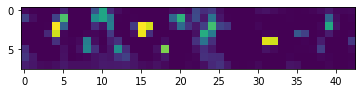

In [22]:
plt.imshow(preds[0, :, :, 0])

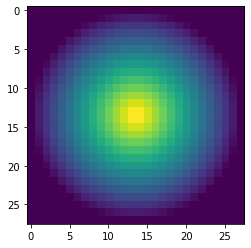

In [23]:
x_axis = np.linspace(-1, 1, 28)[:, None]
y_axis = np.linspace(-1, 1, 28)[None, :]

arr = 1 - np.sqrt(x_axis ** 2 + y_axis ** 2)
arr[arr<0] = 0
plt.imshow(arr)

In [24]:
def draw_heatmap(image, preds, kernel, step = 4):
  import cv2

  rows = preds.shape[0]
  cols = preds.shape[1]
  sy = kernel.shape[0]
  sx = kernel.shape[1]

  hmap = np.zeros(image.shape[0:2])

  for r in range(rows):
    for c in range(cols):
      y = r * step
      x = c * step

      hmap[y:y+sy, x:x+sx] = hmap[y:y+sy, x:x+sx] + preds[r, c] * kernel

  if np.amax(hmap) > 1:
    hmap = hmap / np.amax(hmap)
  hmap2 = (hmap * 255).astype(np.uint8)

  cmap = cv2.applyColorMap(hmap2, cv2.COLORMAP_HOT)
  cmap = cmap[:,:,::-1]
  img = (image * 255).astype(np.uint8)
  ret = 0.3 * img + 0.7 * cmap

  return ret.astype(np.uint8)

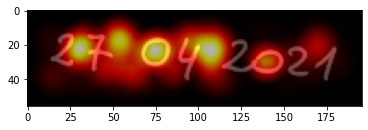

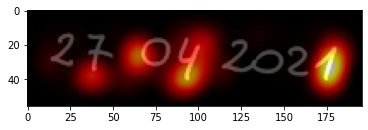

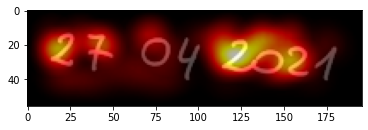

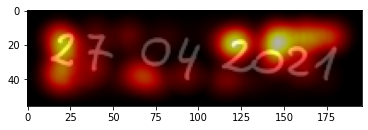

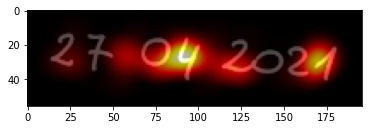

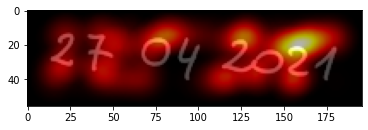

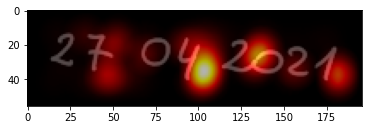

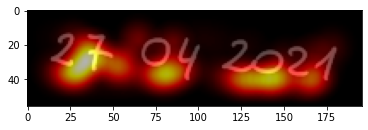

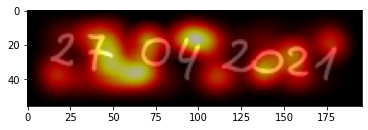

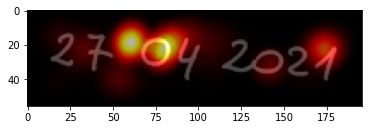

<Figure size 432x288 with 0 Axes>

In [25]:
for i in range(10):
  plt.imshow(draw_heatmap(img[0], preds[0, :, :, i], arr))
  plt.figure()

# Wykorzystanie wag wytrenowanej sieci "klasycznej"

In [26]:
def to_fully_conv(model):
    from keras.layers import InputLayer

    new_model = Sequential()

    input_layer = InputLayer(input_shape=(None, None, 1), name="input_new")

    new_model.add(input_layer)

    for layer in model.layers:
        
        if "Flatten" in str(layer):

            flattened_ipt = True
            f_dim = layer.input_shape

        elif "Dense" in str(layer):
            input_shape = layer.input_shape
            output_dim =  layer.get_weights()[1].shape[0]
            W,b = layer.get_weights()
            if flattened_ipt:
                shape = (f_dim[1],f_dim[2],f_dim[3],output_dim)
                new_W = W.reshape(shape)
                new_layer = Conv2D(output_dim,
                                          (f_dim[1],f_dim[2]),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
                
                new_model.add(new_layer)
                flattened_ipt = False

            else:
                shape = (1,1,input_shape[1],output_dim)
                new_W = W.reshape(shape)
                new_layer = Conv2D(output_dim,
                                          (1,1),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
                
                new_model.add(new_layer)

        else:
            new_model.add(layer)


    return new_model

In [27]:
new_model = to_fully_conv(model)
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  416       
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  12832     
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                  

(1, 8, 43, 10)


0.9999821

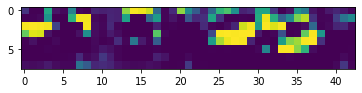

In [28]:
pred2 = new_model.predict(img)
print(pred2.shape)
plt.imshow(pred2[0,:,:,2])
np.amax(pred2[0,:,:,2])

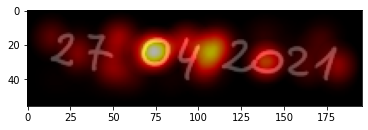

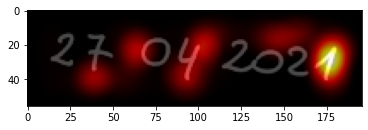

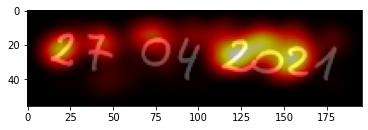

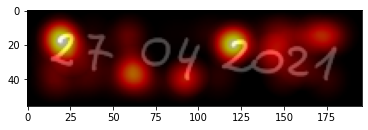

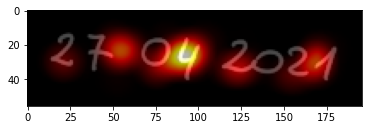

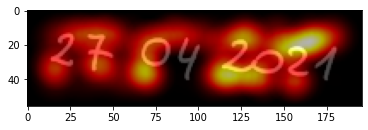

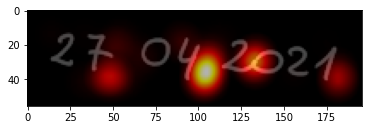

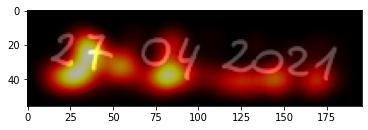

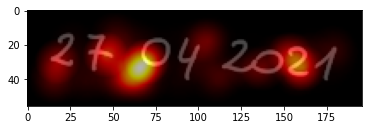

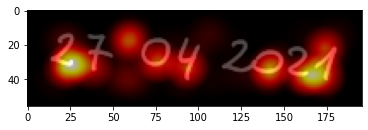

<Figure size 432x288 with 0 Axes>

In [29]:
for i in range(10):
  plt.imshow(draw_heatmap(img[0], pred2[0, :, :, i], arr))
  plt.figure()

# Dodanie klasy negatywnej

In [30]:
cnt = X_train.shape[0]
neg_cnt = 5000
X_neg = np.zeros((neg_cnt, 28, 28, 1))
y_neg = np.ones((neg_cnt)) * 10
print(X_neg.shape)

theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

for i in range(neg_cnt):
  i1 = X_train[random.randint(0, cnt-1)]
  i2 = X_train[random.randint(0, cnt-1)]
  i3 = X_train[random.randint(0, cnt-1)]
  i4 = X_train[random.randint(0, cnt-1)]
  tmp = np.vstack((np.hstack((i1, i2)), np.hstack((i3, i4))))
  tmp = np.pad(tmp[:,:,0], pad_width=14, mode='constant')

  c = np.random.randint(-14, 14, 2)
  c = (np.matmul(c, R) + 42).astype(np.int32)
  tmp2 = tmp[(c[0]-14):(c[0]+14),(c[1]-14):(c[1]+14)]
  X_neg[i,:,:,0] = tmp2

X_train_bg = np.concatenate((X_train, X_neg))
y_train_bg = np.concatenate((y_train, y_neg))
Y_train_bg = np_utils.to_categorical(y_train_bg, nb_classes + 1)
Y_train_bg = np.reshape(Y_train_bg, (Y_train_bg.shape[0], 1, 1, 11))
print(X_train_bg.shape)
print(Y_train_bg.shape)

(5000, 28, 28, 1)
(65000, 28, 28, 1)
(65000, 1, 1, 11)


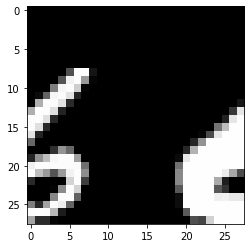

In [31]:
plt.imshow(X_neg[30,:,:,0], cmap='gray')

In [32]:
gen_bg = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

train_generator_bg = gen_bg.flow(X_train_bg, Y_train_bg, batch_size=128, subset='training')
valid_generator_bg = gen_bg.flow(X_train_bg, Y_train_bg, batch_size=128, subset='validation')

In [33]:
modelbg = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
modelbg.add(Conv2D(16, (5, 5), input_shape=(None,None,1))) # 16 different 5x5 kernels -- so 16 feature maps
modelbg.add(Activation('relu') )                       # activation
modelbg.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 2
modelbg.add(Conv2D(32, (5, 5)))                        # 32 different 5x5 kernels -- so 32 feature maps
modelbg.add(Activation('relu'))                        # activation
modelbg.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel


modelbg.add(Conv2D(128, (4, 4)))                        
modelbg.add(Activation('relu'))                        # activation

modelbg.add(Conv2D(10+1, (1, 1)))                              
modelbg.add(Activation('softmax'))                     # softmax activation

modelbg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, None, None, 16)    416       
                                                                 
 activation_8 (Activation)   (None, None, None, 16)    0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 32)    12832     
                                                                 
 activation_9 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                  

In [34]:
adam = tf.optimizers.Adam(learning_rate=0.001)
modelbg.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [35]:
modelbg.fit(train_generator_bg, steps_per_epoch=52000//128, epochs=5, verbose=1, validation_data=valid_generator_bg, validation_steps = 13000 // 128)

Epoch 1/5
390/390 [==============================] - 23s 57ms/step - loss: 0.4392 - accuracy: 0.8649 - val_loss: 0.1693 - val_accuracy: 0.9495
Epoch 2/5
390/390 [==============================] - 21s 55ms/step - loss: 0.1375 - accuracy: 0.9583 - val_loss: 0.1151 - val_accuracy: 0.9657
Epoch 3/5
390/390 [==============================] - 21s 54ms/step - loss: 0.0991 - accuracy: 0.9696 - val_loss: 0.1157 - val_accuracy: 0.9663
Epoch 4/5
390/390 [==============================] - 27s 69ms/step - loss: 0.0856 - accuracy: 0.9736 - val_loss: 0.0782 - val_accuracy: 0.9748
Epoch 5/5
390/390 [==============================] - 21s 54ms/step - loss: 0.0715 - accuracy: 0.9779 - val_loss: 0.0671 - val_accuracy: 0.9800


(1, 8, 43, 11)


0.9999467

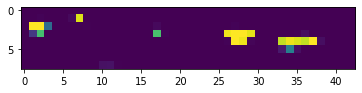

In [36]:
pred3 = modelbg.predict(img)
print(pred3.shape)
plt.imshow(pred3[0,:,:,2])
np.amax(pred3[0,:,:,2])

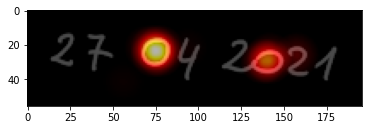

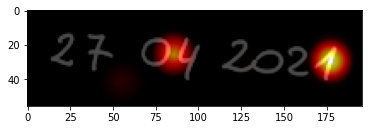

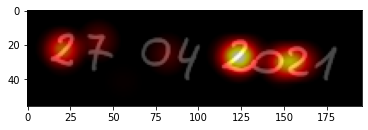

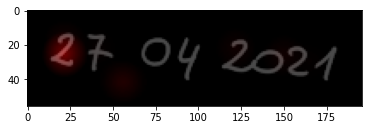

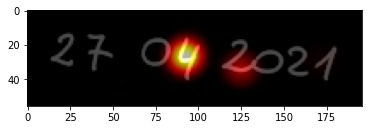

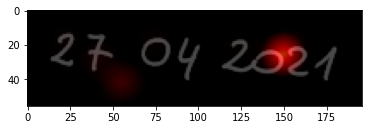

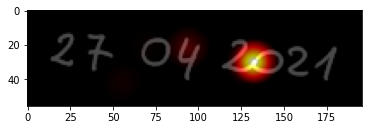

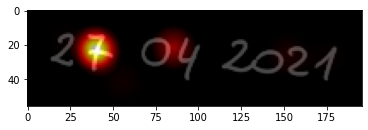

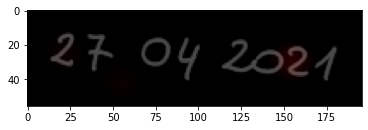

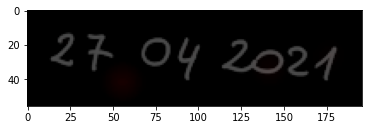

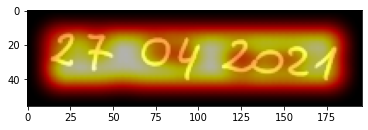

<Figure size 432x288 with 0 Axes>

In [37]:
for i in range(11):
  plt.imshow(draw_heatmap(img[0], pred3[0, :, :, i], arr))
  plt.figure()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


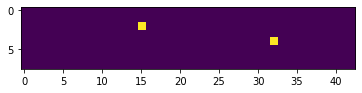

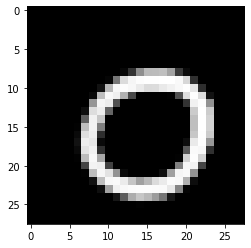

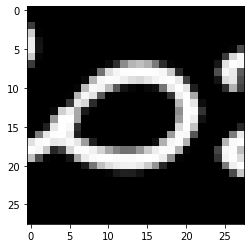

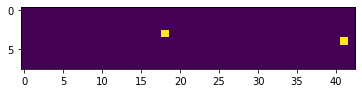

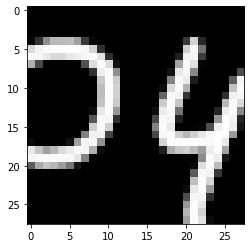

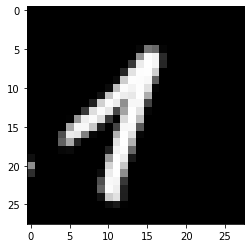

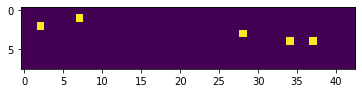

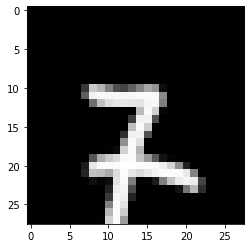

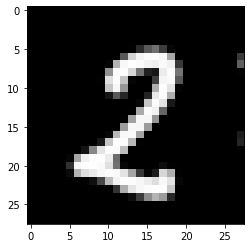

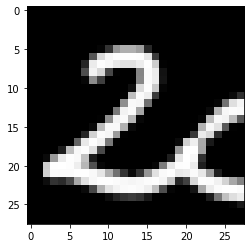

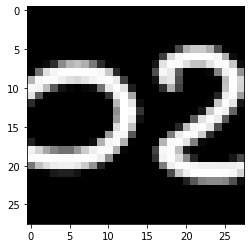

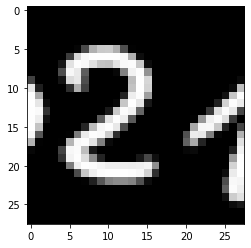

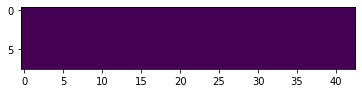

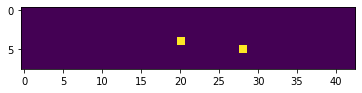

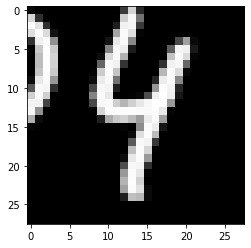

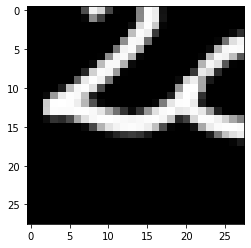

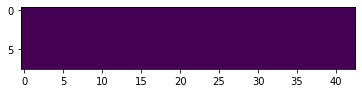

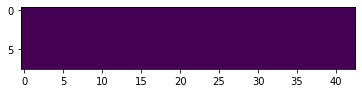

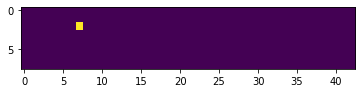

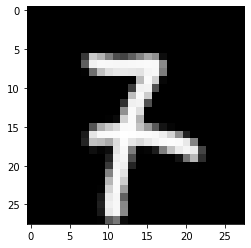

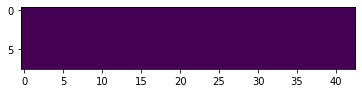

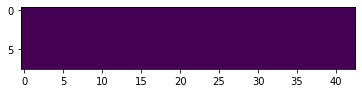

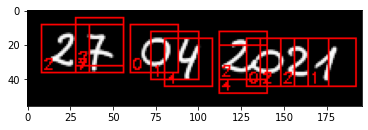

In [38]:
import scipy.ndimage.filters as filters
import cv2

outimg = cv2.cvtColor(img[0], cv2.COLOR_GRAY2BGR)
for digit in range(10):
  p0 = pred3[0, :, :, digit].copy()
  p0[p0 < 0.9] = 0
  preds_max = filters.maximum_filter(p0, 5)
  preds_max = np.bitwise_and((p0 == preds_max), (p0 > 0))
  plt.figure()
  plt.imshow(preds_max)

  ids = np.nonzero(preds_max)
  step = 4
  sz = 28
  for (y,x) in zip(*ids):
    cv2.rectangle(outimg, (x*step,y*step), (x*step+sz, y*step+sz), (1, 0, 0))
    cv2.putText(outimg, str(digit), (x*step+1, y*step+sz-2), cv2.FONT_HERSHEY_DUPLEX, 0.3, (1, 0, 0), 1, cv2.LINE_AA)
    plt.figure()
    plt.imshow(img[0][y*step:y*step+sz,x*step:x*step+sz,0],cmap='gray')

plt.figure()
plt.imshow(outimg)